In [1]:
import pandas as pd
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import itertools
import os, sys, datetime

In [2]:
import time
from tqdm import tqdm_notebook
new_data=False
filter_ths = 10
num_epochs =150
learning_rate = 0.001
batch_size = 150
class MLP(nn.Module):
    def __init__(self, num_classes, input_size):
        super(MLP,self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dt1 = nn.Dropout(0.25)
        self.linear2 = nn.Linear(in_features=1024, out_features=256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dt2 = nn.Dropout(0.25)
        self.linear3 = nn.Linear(in_features=256, out_features= num_classes)
        
    def forward(self, x):
        x = self.bn1(self.linear1(x))
        x = F.relu(x)
        # x = self.dt1(x)
        x = self.bn2(self.linear2(x))
        x = F.relu(x)
        # x = self.dt2(x)
        x = self.linear3(x)
        x = F.softmax(x, dim=1)
        return x
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data, 0, 0.01)
                # m.weight.data.normal_(0,0.01)
                m.bias.data.zero_()

In [3]:
if new_data==True:
    raw_data = pd.read_csv('./4602_SARS-CoV-2_pima_0708.csv')
else:
    # npy path
    train_npy = [f'./dataset2/numpy_train_test_split_added time/X_train_{filter_ths}up_weeks.npy', f'./dataset2/numpy_train_test_split_added time/y_train_{filter_ths}up_weeks.npy']
    test_npy = [f'./dataset2/numpy_train_test_split_added time/X_test_{filter_ths}up_weeks.npy', f'./dataset2/numpy_train_test_split_added time/y_test_{filter_ths}up_weeks.npy']


In [4]:
# 讀取新數據集
def filter_dataset(data, filter_ths=50):
    class_count = data['lineage'].value_counts() #抓csv裡面的class label
    class_filter = class_count[class_count[:]>filter_ths] #根據def設定的過濾數值[boolean{total single class nums > ths}]篩選出符合Thresholds的Class
    print(class_filter)
    print('total data=', sum(class_filter))
    class_list = list(dict(class_filter).keys()) #抓出過濾後的class清單名字
    X = []
    y = []
    for i in np.array(data):
        for idx, j in enumerate(class_list): #利用enumerate 同時取得Class list的index位置和名稱
            if i[0] ==j:
                X.append(i[1::].astype(np.float16))
                y.append(idx)

    # y = F.one_hot(torch.tensor(y), num_classes=len(class_list)) #轉成onehot label -> ['A','B','C'] -> [[1,0,0],[0,1,0],[0,0,1]]
    return np.array(X), np.array(y), class_list

# 讀取以儲存npy資料集

class data_loader:
    def __init__(self, x_train, y_train, x_test, y_test):

        self.x_train = np.array(x_train)
        self.x_test = np.array(x_test)
        self.y_train = np.array(y_train)
        self.y_test = np.array(y_test)
        print(self.x_train.shape, self.y_train.shape, self.x_test.shape, self.y_test.shape)
    def get_index(self, data_list, GT_list, b):
        labels = []
        datas =[]
        for patch, i in enumerate(GT_list):
            for index, label in enumerate(b):
                if i==label:
                    labels.append(index)
                    datas.append(data_list[patch])
        return datas, labels

    def npy_loading(self):
        # train processing
        b1, _, _, w1= np.unique(self.y_train,return_counts=True,return_index=True,return_inverse=True)
        # test(valid) processing
        b2, _, _, w2= np.unique(self.y_test,return_counts=True,return_index=True,return_inverse=True)
        # print('train data count')
        # df1 = pd.DataFrame(w1)
        # df1.index = b1
        # print(df1)
        # print('test data count')
        # df2 = pd.DataFrame(w2)
        # df2.index = b2
        # print(df2)
        X_train, Y_train = self.get_index(self.x_train, self.y_train, b2)
        X_test, Y_test = self.get_index(self.x_test, self.y_test, b2)

        return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test), b2

try:
    X, y, class_dict = filter_dataset(raw_data, filter_ths=filter_ths)
    np.save(f'Cov-2_f-{filter_ths}_X', X)
    np.save(f'Cov-2_f-{filter_ths}_y', y)
    X = np.load('./Cov-2_f-50_X.npy')
    y = np.load('./Cov-2_f-50_y.npy')
    print('X shape:', X.shape)
    print('y shape:', y.shape)
    class_n = max(y)+1
    # zip pytorch tensor dataloader
    datas_zip = TensorDataset(torch.tensor(X), torch.tensor(y)) #zip X, y
    # # split train and valid dataset
    train_size = int((len(datas_zip)*0.75))
    test_size = len(datas_zip)-train_size
    train_dataset, test_dataset = torch.utils.data.random_split(datas_zip, [train_size, test_size])
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
except:
    # dataset npy loading
    loader = data_loader(np.load(train_npy[0], allow_pickle=True), np.load(train_npy[1], allow_pickle=True), 
                        np.load(test_npy[0], allow_pickle=True), np.load(test_npy[1], allow_pickle=True))

    X_train, y_train,X_test, y_test, test_class = loader.npy_loading()
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    class_n = len(test_class)
    print('train class', max(y_train)+1, 'test class', max(y_test)+1)


    # pytorch data zip processing
    train_zip = TensorDataset(torch.tensor(X_train), torch.tensor(y_train)) #zip X, y
    test_zip = TensorDataset(torch.tensor(X_test), torch.tensor(y_test)) #zip X, y
    train_loader = DataLoader(dataset=train_zip, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=test_zip, batch_size=batch_size, shuffle=False)

(1757, 29033) (1757,) (586, 29033) (586,)
(1757, 29033) (1757,) (586, 29033) (586,)
train class 8 test class 8


In [5]:
model = MLP(class_n, input_size=len(train_zip[0][0])).cuda()
model.initialize_weights()
# summary(model, (1, X_test.shape[1]))

In [6]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
tloss_stack, vloss_stack, t_acc_stack, v_acc_stack = [], [], [], []
min_valid_loss = np.inf
for epoch in tqdm_notebook(range(num_epochs)):
    # Training
    train_loss = 0.0
    batch_train_acc = 0.00
    for data, labels in train_loader:
        # Forward pass
        model.train()
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        optimizer.zero_grad()

        output = model(data.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()*data.size(0)
        batch_train_acc += accuracy(output, labels)
    tloss_stack.append(loss)
    batch_train_acc /= len(train_loader)
    t_acc_stack.append(batch_train_acc)

    # Validation
    valid_loss = 0.0
    batch_valid_acc = 0.00
    model.eval()
    for data, labels in valid_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        output = model(data.float())
        loss = criterion(output, labels)
        valid_loss = loss.item()*data.size(0)
        batch_valid_acc += accuracy(output, labels)
    vloss_stack.append(loss)
    batch_valid_acc /= len(valid_loader)
    v_acc_stack.append(batch_valid_acc)
    if min_valid_loss > valid_loss:
        # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
          
        # Saving State Dict
        torch.save({'state_dict': model.state_dict()}, f'./pth/week_saved_model_{filter_ths}.pth.tar')


    # print(f'Epoch {epoch+1} \t\t \
    #     Train L: {(train_loss / len(train_loader)):.5f} \t\t Train Acc: {batch_train_acc:.5f}\t\t \
    #     Valid L: {(valid_loss / len(valid_loader)):.5f} \t\t Valid Acc: {batch_valid_acc:.5f}')


/home/john/anaconda3/envs/lstm_pyt/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/150 [00:00<?, ?it/s]

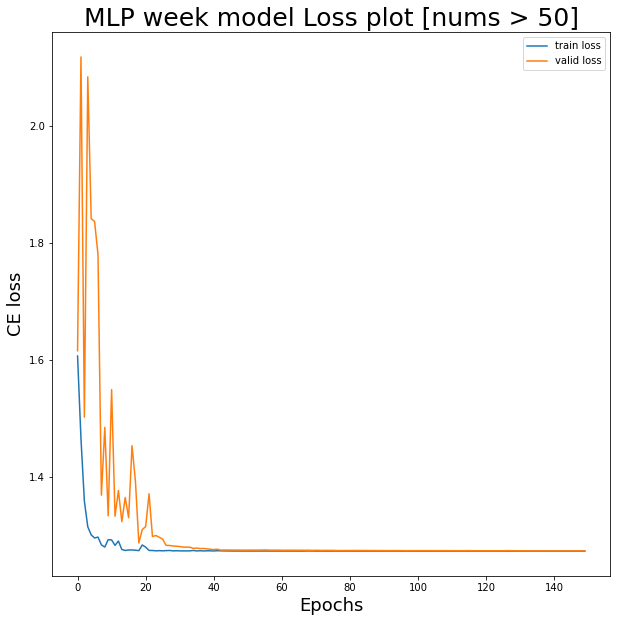

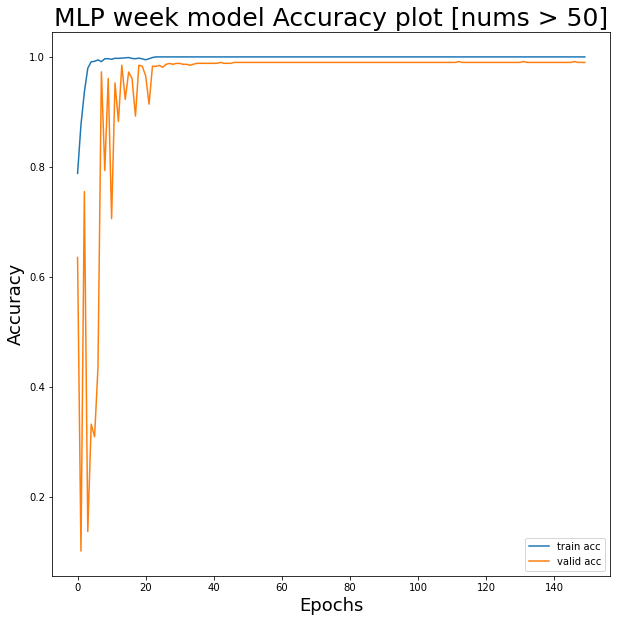

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(tloss_stack, label='train loss')
plt.plot(vloss_stack, label='valid loss')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('CE loss',fontsize=18)
plt.title(f'MLP week model Loss plot [nums > {filter_ths}]', fontsize=25)
plt.legend()
plt.savefig(f'./results/{filter_ths}_loss_MLP.jpg')

plt.figure(figsize=(10,10))
plt.plot(t_acc_stack, label='train acc')
plt.plot(v_acc_stack, label='valid acc')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.title(f'MLP week model Accuracy plot [nums > {filter_ths}]', fontsize=25)
plt.legend()
plt.savefig(f'./results/{filter_ths}_accuracy_MLP_week.jpg')

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model = MLP(class_n, input_size=len(train_zip[0][0])).cuda()
checkpoint = torch.load(f'./pth/week_saved_model_{filter_ths}.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

MLP(
  (linear1): Linear(in_features=29033, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dt1): Dropout(p=0.25, inplace=False)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dt2): Dropout(p=0.25, inplace=False)
  (linear3): Linear(in_features=256, out_features=8, bias=True)
)

In [10]:
y_pred = []
y_true = [] 
for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        output = model(data.float())
        _, preds = torch.max(output, 1) 
        y_pred.extend(preds.view(-1).detach().cpu().numpy())    
        y_true.extend(labels.view(-1).detach().cpu().numpy())   
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

1.0


In [11]:
y_pred = []
y_true = [] 
for data, labels in valid_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        output = model(data.float())
        _, preds = torch.max(output, 1) 
        y_pred.extend(preds.view(-1).detach().cpu().numpy())    
        y_true.extend(labels.view(-1).detach().cpu().numpy())
print(accuracy_score(y_true, y_pred))

0.9897610921501706


[0.96923077 1.         1.         0.99354839 1.         0.98148148
 1.         0.97297297]
0.9897610921501706


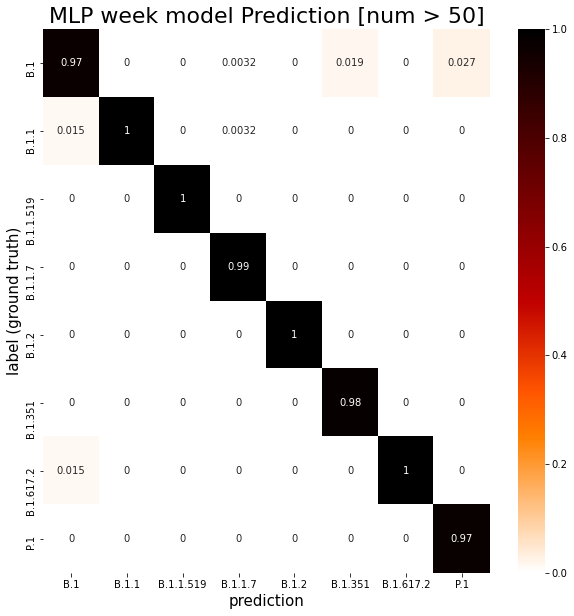

In [12]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize='pred') 
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)
print(per_cls_acc)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))
df_cm = pd.DataFrame(cf_matrix, test_class, test_class)
plt.figure(figsize = (30,30))
sns.heatmap(df_cm, annot=True, cmap='gist_heat_r')
plt.xlabel("prediction", fontsize =15)
plt.ylabel("label (ground truth)", fontsize =15)
plt.title(f'MLP week model Prediction [num > {filter_ths}]', fontsize=22)
plt.savefig(f'./results/{filter_ths}_CM_week.jpg')